In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from matplotlib.animation import FuncAnimation

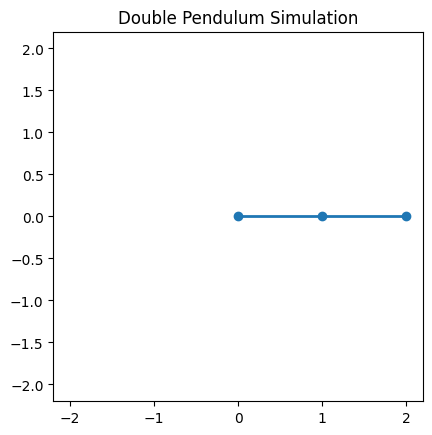

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from matplotlib.animation import FuncAnimation

# --- Physical constants ---
g = 9.81       # acceleration due to gravity (m/s^2)
L1, L2 = 1.0, 1.0  # lengths of pendulums
m1, m2 = 1.0, 1.0  # masses

# --- Equations of motion ---
def double_pendulum_deriv(t, y):
    θ1, z1, θ2, z2 = y

    delta = θ2 - θ1
    den1 = (m1 + m2) * L1 - m2 * L1 * np.cos(delta)**2
    den2 = (L2 / L1) * den1

    dθ1_dt = z1
    dθ2_dt = z2

    dz1_dt = (m2 * L1 * z1**2 * np.sin(delta) * np.cos(delta) +
              m2 * g * np.sin(θ2) * np.cos(delta) +
              m2 * L2 * z2**2 * np.sin(delta) -
              (m1 + m2) * g * np.sin(θ1)) / den1

    dz2_dt = (-m2 * L2 * z2**2 * np.sin(delta) * np.cos(delta) +
              (m1 + m2) * (g * np.sin(θ1) * np.cos(delta) -
              L1 * z1**2 * np.sin(delta) -
              g * np.sin(θ2))) / den2

    return [dθ1_dt, dz1_dt, dθ2_dt, dz2_dt]

# --- Initial conditions ---
θ1_0 = np.pi / 2  # initial angle for pendulum 1
θ2_0 = np.pi / 2  # initial angle for pendulum 2
z1_0 = 0.0        # initial angular velocity for pendulum 1
z2_0 = 0.0        # initial angular velocity for pendulum 2

y0 = [θ1_0, z1_0, θ2_0, z2_0]

# --- Time span ---
t_span = (0, 20)
t_eval = np.linspace(*t_span, 1000)

# --- Solve ODE ---
sol = solve_ivp(double_pendulum_deriv, t_span, y0, t_eval=t_eval, rtol=1e-10, atol=1e-10)

# --- Convert angles to x, y coordinates ---
θ1, θ2 = sol.y[0], sol.y[2]
x1 = L1 * np.sin(θ1)
y1 = -L1 * np.cos(θ1)

x2 = x1 + L2 * np.sin(θ2)
y2 = y1 - L2 * np.cos(θ2)

# --- Animation ---
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim(-2.2, 2.2)
ax.set_ylim(-2.2, 2.2)
line, = ax.plot([], [], 'o-', lw=2)

def update(frame):
    thisx = [0, x1[frame], x2[frame]]
    thisy = [0, y1[frame], y2[frame]]
    line.set_data(thisx, thisy)
    return line,

ani = FuncAnimation(fig, update, frames=len(t_eval), blit=True, interval=1000 * t_eval[1] / len(t_eval))
plt.title("Double Pendulum Simulation")
plt.show()


In [ ]:
####skmdfksldlkgd